# Autoregressive Distributed Lag (ARDL) models


## ARDL Models

Autoregressive Distributed Lag (ARDL) models extend Autoregressive models with lags of explanatory variables. While ARDL models are technically AR-X models, the key difference is that ARDL models focus on the exogenous variables and selecting the correct lag structure from both the endogenous variable and the exogenous variables.  ARDL models are also closely related to Vector Autoregressions, and a single ARDL is effectively one row of a VAR.  The key distinction is that an ARDL assumes that the exogenous variables are exogenous in the sense that it is not necessary to include the endogenous variable as a predictor of the exogenous variables.

The full specification of ARDL models is

$$
Y_t = \underset{\text{Constant and Trend}}{\underbrace{\delta_0 + \delta_1 t + \ldots + \delta_k t^k}} 
      + \underset{\text{Seasonal}}{\underbrace{\sum_{i=0}^{s-1} \gamma_i S_i}}
      + \underset{\text{Autoregressive}}{\underbrace{\sum_{p=1}^P \phi_p Y_{t-p}}}
      + \underset{\text{Distributed Lag}}{\underbrace{\sum_{k=1}^M \sum_{j=0}^{Q_k} \beta_{k,j} X_{k, t-j}}}
      + \underset{\text{Fixed}}{\underbrace{Z_t \Gamma}} + \epsilon_t
$$

The terms in the model are:

* $\delta_i$: constant and deterministic time regressors.  Set using `trend`.
* $S_i$ are seasonal dummies which are included if `seasonal=True`.
* $X_{k,t-j}$ are the exogenous regressors. There are a number of formats that can be used to specify which lags are included. Note that the included lag lengths do no need to be the same. If `causal=True`, then the lags start with lag 1. Otherwise lags begin with 0 so that the model included the contemporaneous relationship between $Y_t$ and $X_t$.
* $Z_t$ are any other fixed regressors that are not part of the distributed lag specification. In practice these regressors may be included when they do no contribute to the long run-relationship between $Y_t$ and the vector of exogenous variables $X_t$.
* $\{\epsilon_t\}$ is assumed to be a White Noise process

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Data

This notebook makes use of money demand data from Denmark, as first used in  S. Johansen and K. Juselius (1990).  The key variables are:

* `lrm`: Log of real money measured using M2
* `lry`: Log of real income
* `ibo`: Interest rate on bonds
* `ide`: Interest rate of bank deposits

The standard model uses `lrm` as the dependent variable and the other three as exogenous drivers.

Johansen, S. and Juselius, K. (1990), Maximum Likelihood Estimation and Inference on Cointegration – with Applications to the Demand for Money, Oxford Bulletin of Economics and Statistics, 52, 2, 169–210.

We start by loading the data and examining it.

In [2]:
from statsmodels.datasets.danish_data import load
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

data = load().data
data = data[["lrm", "lry", "ibo", "ide"]]
data.tail()

,lrm,lry,ibo,ide
period,,,,
1986-07-01,12.056189,6.098992,0.111500,0.067941
1986-10-01,12.071628,6.080706,0.114267,0.075396
1987-01-01,12.027952,6.061175,0.119333,0.076653
1987-04-01,12.039788,6.063730,0.117333,0.076259
1987-07-01,12.015294,6.050830,0.118967,0.075163


We plot the demeaned data so that all series appear on the same scale. The `lrm` series appears to be non-stationary, as does `lry`. The stationarity of the other two is less obvious.

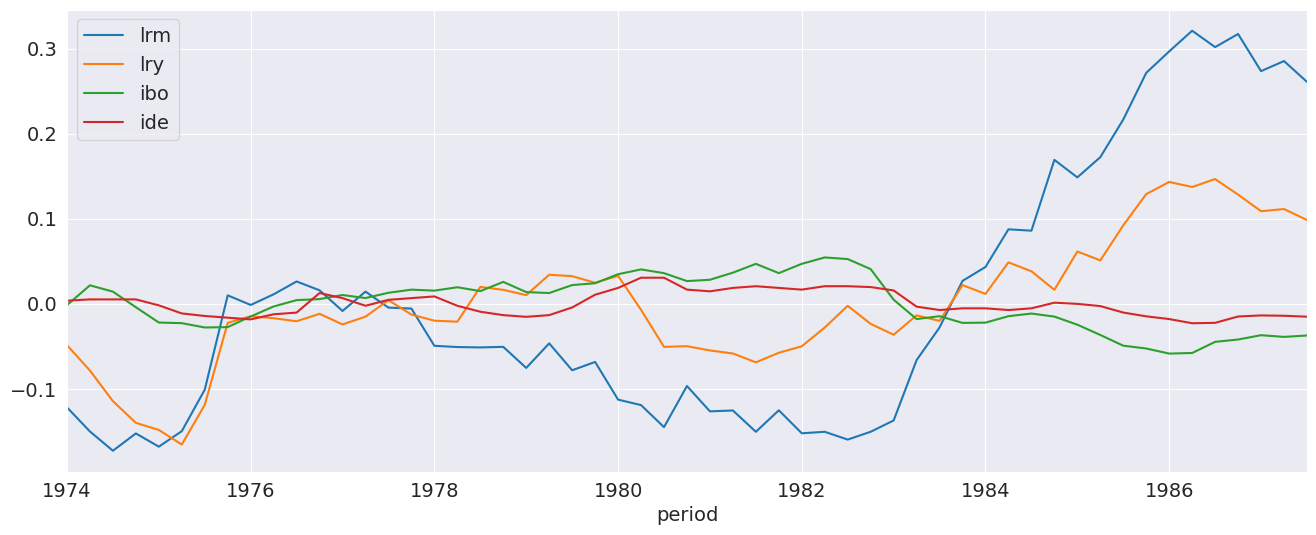

In [3]:
_ = (data - data.mean()).plot()

### Model Selection

`ardl_select_order` can be used to automatically select the order. Here we use min the minimum AIC among all modes that consider up to 3 lags of the endogenous variable and 3 lags of each exogenous variable. `trend="c"` indicates that a constant should be included in the model.

In [4]:
sel_res = ardl_select_order(
    data.lrm, 3, data[["lry", "ibo", "ide"]], 3, ic="aic", trend="c"
)
print(f"The optimal order is: {sel_res.model.ardl_order}")

The optimal order is: (3, 1, 3, 2)


The optimal order is returned as the number of lags of the endogenous variable followed by each of the exogenous regressors.  The attribute `model` on `sel_res` contains the model `ARDL` specification which can be used to call `fit`. Here we look at the summary where the `L#` indicates that lag length (e.g., `L0` is no lag, i.e., $X_{k,t}$, `L2` is 2 lags, i.e., $X_{k,t-2}$).

In [5]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                    lrm   No. Observations:                   55
Model:               ARDL(3, 1, 3, 2)   Log Likelihood                 139.513
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Mon, 08 Sep 2025   AIC                           -251.026
Time:                        14:04:35   BIC                           -223.708
Sample:                    10-01-1974   HQIC                          -240.553
                         - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6202      0.568      4.615      0.000       1.472       3.769
lrm.L1         0.3192      0.137      2.336      0.025       0.043       0.596
lrm.L2         0.5326      0.132      4.024      0.000       0.265       0.800
lrm.L3        -0.2687      0.102     -2.631      0.012      -0.475      -0.062
lry.L0         0.6728      0.131      5.129      0.000       0.407       0.938
lry.L1        -0.2574      0.147     -1.749      0.088      -0.555       0.040
ibo.L0        -1.0785      0.322     -3.353      0.002      -1.729      -0.428
ibo.L1        -0.1062      0.586     -0.181      0.857      -1.291       1.079
ibo.L2         0.2877      0.569      0.505      0.616      -0.863       1.439
ibo.L3        -0.9947      0.393     -2.534      0.015      -1.789      -0.201
ide.L0         0.1255      0.554      0.226      0.822      -0.996       1.247
ide.L1        -0.3280      0.721     -0.455      0.652      -1.787       1.131
ide.L2         1.4079      0.552      2.550      0.015       0.291       2.524
==============================================================================
"""

### Global searches

The selection criteria can be switched the BIC which chooses a smaller model. Here we also use the `glob=True` option to perform a global search which considers models with any subset of lags up to the maximum lag allowed (3 here).  This option lets the model selection choose non-contiguous lag specifications.

In [6]:
sel_res = ardl_select_order(
    data.lrm, 3, data[["lry", "ibo", "ide"]], 3, ic="bic", trend="c", glob=True
)
sel_res.model.ardl_order

(3, 0, 3, 2)

While the `ardl_order` shows the largest included lag of each variable, `ar_lags` and `dl_lags` show the specific lags included.  The AR component is regular in the sense that all 3 lags are included.  The DL component is not since `ibo` selects only lags 0 and 3 and ide selects only lags 2.

In [7]:
sel_res.model.ar_lags

[1, 2, 3]

In [8]:
sel_res.model.dl_lags

{'lry': [0], 'ibo': [0, 3], 'ide': [2]}

We can take a look at the best performing models according to the BIC which are stored in the `bic` property. `ibo` at lags 0 and 3 is consistently selected, as is `ide` at either lag 2 or 3, and `lry` at lag 0. The selected AR lags vary more, although all of the best specifications select some. 

In [9]:
for i, val in enumerate(sel_res.bic.head(10)):
    print(f"{i+1}: {val}")

1: ((1, 2, 3), {'lry': (0,), 'ibo': (0, 3), 'ide': (2,)})
2: ((1, 2, 3), {'lry': (0, 1), 'ibo': (0, 3), 'ide': (2,)})
3: ((2,), {'lry': (0,), 'ibo': (0, 3), 'ide': (3,)})
4: ((1, 2, 3), {'lry': (0, 2), 'ibo': (0, 3), 'ide': (2,)})
5: ((2,), {'lry': (0, 2), 'ibo': (0, 3), 'ide': (2,)})
6: ((2,), {'lry': (0, 3), 'ibo': (0, 3), 'ide': (2,)})
7: ((2, 3), {'lry': (0,), 'ibo': (0, 3), 'ide': (2,)})
8: ((1, 2, 3), {'lry': (0,), 'ibo': (0, 3), 'ide': (2, 3)})
9: ((2,), {'lry': (0,), 'ibo': (0, 3), 'ide': (2, 3)})
10: ((1, 2), {'lry': (0,), 'ibo': (0, 3), 'ide': (3,)})


### Direct Parameterization

ARDL models can be directly specified using the `ARDL` class.  The first argument is the endogenous variable ($Y_t$). The second is the AR lags. It can be a constant, in which case lags 1, 2, ..., $P$ are included, or a list of specific lags indices to include (e.g., `[1, 4]`).  The third are the exogenous variables, and the fourth is the list of lags to include.  This can be one of

* An `int`: Include lags 0, 1, ..., Q
* A dict with column names when `exog` is a `DataFrame` or numeric column locations when `exog` is a NumPy array (e.g., `{0:1, 1: 2, 2:3}`, would match the specification below if a NumPy array was used.
* A dict with column names (DataFrames) or integers (NumPy arrays) that contains a list of specific lags to include (e.g., `{"lry":[0,2], "ibo":[1,2]}`).

The specification below matches that model selected by `ardl_select_order`.

In [10]:
res = ARDL(
    data.lrm, 2, data[["lry", "ibo", "ide"]], {"lry": 1, "ibo": 2, "ide": 3}, trend="c"
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                    lrm   No. Observations:                   55
Model:               ARDL(2, 1, 2, 3)   Log Likelihood                 136.252
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Mon, 08 Sep 2025   AIC                           -246.504
Time:                        14:04:44   BIC                           -220.890
Sample:                    10-01-1974   HQIC                          -236.654
                         - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4440      0.546      4.479      0.000       1.342       3.546
lrm.L1         0.2695      0.139      1.944      0.059      -0.011       0.550
lrm.L2         0.3409      0.114      2.993      0.005       0.111       0.571
lry.L0         0.6344      0.145      4.368      0.000       0.341       0.928
lry.L1        -0.2426      0.159     -1.527      0.134      -0.563       0.078
ibo.L0        -1.1316      0.359     -3.157      0.003      -1.856      -0.408
ibo.L1         0.1056      0.640      0.165      0.870      -1.186       1.397
ibo.L2        -0.8347      0.497     -1.679      0.101      -1.839       0.170
ide.L0         0.2849      0.614      0.464      0.645      -0.954       1.524
ide.L1         0.0433      0.805      0.054      0.957      -1.582       1.669
ide.L2         0.4429      0.770      0.575      0.568      -1.112       1.998
ide.L3         0.3671      0.515      0.713      0.480      -0.673       1.408
==============================================================================
"""

### NumPy Data

Below we see how the specification of ARDL models differs when using NumPy arrays.  The key difference is that the keys in the dictionary are now integers which indicate the column of `x` to use. This model is identical to the previously fit model and all key value match exactly (e.g., Log Likelihood).

In [11]:
y = np.asarray(data.lrm)
x = np.asarray(data[["lry", "ibo", "ide"]])
res = ARDL(y, 2, x, {0: 1, 1: 2, 2: 3}, trend="c").fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               ARDL(2, 1, 2, 3)   Log Likelihood                 136.252
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Mon, 08 Sep 2025   AIC                           -246.504
Time:                        14:04:44   BIC                           -220.890
Sample:                             3   HQIC                          -236.654
                                   55                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4440      0.546      4.479      0.000       1.342       3.546
y.L1           0.2695      0.139      1.944      0.059      -0.011       0.550
y.L2           0.3409      0.114      2.993      0.005       0.111       0.571
x0.L0          0.6344      0.145      4.368      0.000       0.341       0.928
x0.L1         -0.2426      0.159     -1.527      0.134      -0.563       0.078
x1.L0         -1.1316      0.359     -3.157      0.003      -1.856      -0.408
x1.L1          0.1056      0.640      0.165      0.870      -1.186       1.397
x1.L2         -0.8347      0.497     -1.679      0.101      -1.839       0.170
x2.L0          0.2849      0.614      0.464      0.645      -0.954       1.524
x2.L1          0.0433      0.805      0.054      0.957      -1.582       1.669
x2.L2          0.4429      0.770      0.575      0.568      -1.112       1.998
x2.L3          0.3671      0.515      0.713      0.480      -0.673       1.408
==============================================================================
"""

### Causal models

Using the `causal=True` flag eliminates lag 0 from the DL components, so that all variables included in the model are known at time $t-1$ when modeling $Y_t$.

In [12]:
res = ARDL(
    data.lrm,
    2,
    data[["lry", "ibo", "ide"]],
    {"lry": 1, "ibo": 2, "ide": 3},
    trend="c",
    causal=True,
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                    lrm   No. Observations:                   55
Model:               ARDL(2, 1, 2, 3)   Log Likelihood                 121.130
Method:               Conditional MLE   S.D. of innovations              0.025
Date:                Mon, 08 Sep 2025   AIC                           -222.260
Time:                        14:04:44   BIC                           -202.557
Sample:                    10-01-1974   HQIC                          -214.683
                         - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3885      0.696      3.434      0.001       0.987       3.790
lrm.L1         0.4294      0.169      2.538      0.015       0.088       0.770
lrm.L2         0.2777      0.139      2.003      0.051      -0.002       0.557
lry.L1         0.2064      0.139      1.481      0.146      -0.074       0.487
ibo.L1        -1.2787      0.467     -2.736      0.009      -2.221      -0.337
ibo.L2        -0.3403      0.568     -0.600      0.552      -1.484       0.804
ide.L1        -0.1234      0.746     -0.165      0.869      -1.627       1.380
ide.L2         0.5001      0.978      0.511      0.612      -1.471       2.472
ide.L3         0.6106      0.656      0.931      0.357      -0.711       1.933
==============================================================================
"""

## Unconstrained Error Correction Models (UECM)

Unconstrained Error Correction Models reparameterize ARDL model to focus on the long-run component of a time series.  The reparameterized model is

$$
\Delta Y_t = \underset{\text{Constant and Trend}}{\underbrace{\delta_0 + \delta_1 t + \ldots + \delta_k t^k}} 
      + \underset{\text{Seasonal}}{\underbrace{\sum_{i=0}^{s-1} \gamma_i S_i}}
      + \underset{\text{Long-Run}}{\underbrace{\lambda_0 Y_{t-1} + \sum_{b=1}^M \lambda_i  X_{b,t-1}}}
      + \underset{\text{Autoregressive}}{\underbrace{\sum_{p=1}^P \phi_p \Delta Y_{t-p}}}
      + \underset{\text{Distributed Lag}}{\underbrace{\sum_{k=1}^M \sum_{j=0}^{Q_k} \beta_{k,j} \Delta X_{k, t-j}}}
      + \underset{\text{Fixed}}{\underbrace{Z_t \Gamma}} + \epsilon_t
$$


Most of the components are the same.  The key differences are:

* The levels only enter at lag 1
* All other lags of $Y_t$ or $X_{k,t}$ are differenced

Due to their structure, UECM models _do not_ support irregular lag specifications, and so lags specifications must be integers. The AR lag length must be an integer or `None`, while the DL lag specification can be an integer or a dictionary of integers.  Other options such as `trend`, `seasonal`, and `causal` are identical.

Below we select a model and then using the class method `from_ardl` to construct the UECM.  The parameter estimates prefixed with `D.` are differences.

In [13]:
from statsmodels.tsa.api import UECM

sel_res = ardl_select_order(
    data.lrm, 3, data[["lry", "ibo", "ide"]], 3, ic="aic", trend="c"
)

ecm = UECM.from_ardl(sel_res.model)
ecm_res = ecm.fit()
ecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:                  D.lrm   No. Observations:                   55
Model:               UECM(3, 1, 3, 2)   Log Likelihood                 139.513
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Mon, 08 Sep 2025   AIC                           -251.026
Time:                        14:04:45   BIC                           -223.708
Sample:                    10-01-1974   HQIC                          -240.553
                         - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6202      0.568      4.615      0.000       1.472       3.769
lrm.L1        -0.4169      0.092     -4.548      0.000      -0.602      -0.231
lry.L1         0.4154      0.118      3.532      0.001       0.177       0.653
ibo.L1        -1.8917      0.391     -4.837      0.000      -2.683      -1.101
ide.L1         1.2053      0.447      2.697      0.010       0.301       2.109
D.lrm.L1      -0.2639      0.102     -2.590      0.013      -0.470      -0.058
D.lrm.L2       0.2687      0.102      2.631      0.012       0.062       0.475
D.lry.L0       0.6728      0.131      5.129      0.000       0.407       0.938
D.ibo.L0      -1.0785      0.322     -3.353      0.002      -1.729      -0.428
D.ibo.L1       0.7070      0.469      1.508      0.140      -0.241       1.655
D.ibo.L2       0.9947      0.393      2.534      0.015       0.201       1.789
D.ide.L0       0.1255      0.554      0.226      0.822      -0.996       1.247
D.ide.L1      -1.4079      0.552     -2.550      0.015      -2.524      -0.291
==============================================================================
"""

### Cointegrating Relationships

Because the focus is on the long-run relationship, the results of UECM model fits contains a number of properties that focus on the long-run relationship. These are all prefixed `ci_`, for cointegrating.  `ci_summary` contains the normalized estimates of the cointegrating relationship and associated estimated values. 

In [14]:
ecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,-6.2857,0.772,-8.143,0.000,-7.847,-4.724
lrm.L1,1.0000,0,nan,nan,1.000,1.000
lry.L1,-0.9965,0.124,-8.041,0.000,-1.247,-0.746
ibo.L1,4.5381,0.520,8.722,0.000,3.486,5.591
ide.L1,-2.8915,0.995,-2.906,0.004,-4.904,-0.879


`ci_resids` contains the long-run residual, which is the error the drives figure changes in $\Delta Y_t$.

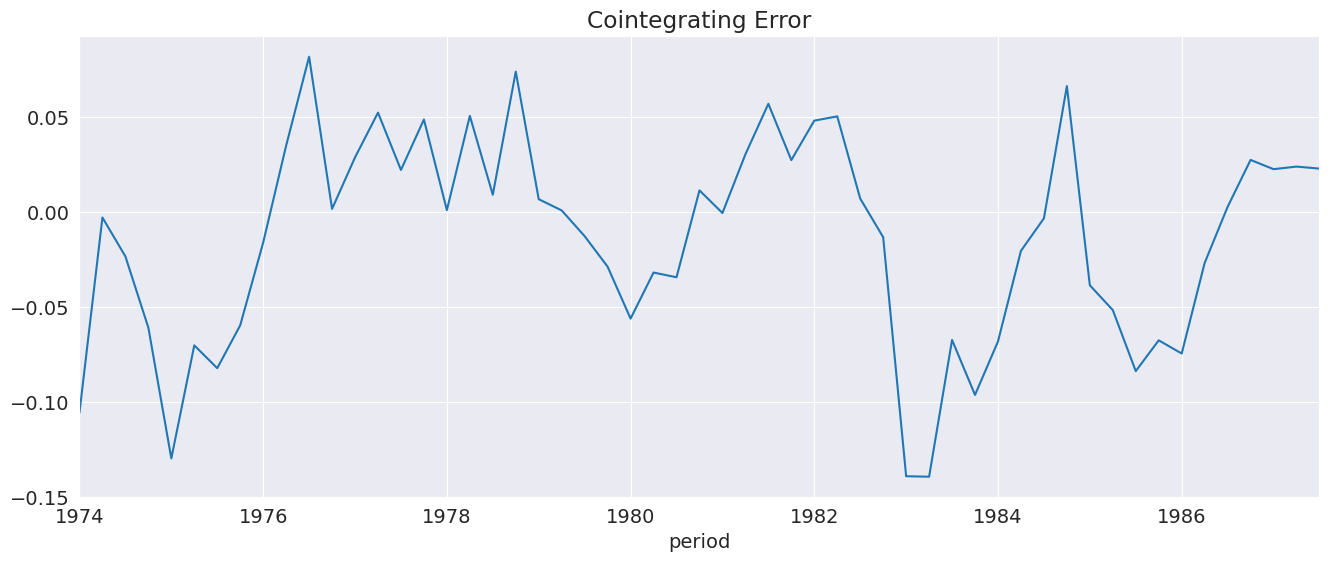

In [15]:
_ = ecm_res.ci_resids.plot(title="Cointegrating Error")

### Seasonal Dummies

Here we add seasonal terms, which appear to be statistically significant.

In [16]:
ecm = UECM(data.lrm, 2, data[["lry", "ibo", "ide"]], 2, seasonal=True)
seasonal_ecm_res = ecm.fit()
seasonal_ecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                UECM Model Results                                
==================================================================================
Dep. Variable:                      D.lrm   No. Observations:                   55
Model:             Seas. UECM(2, 2, 2, 2)   Log Likelihood                 150.609
Method:                   Conditional MLE   S.D. of innovations              0.014
Date:                    Mon, 08 Sep 2025   AIC                           -269.218
Time:                            14:04:45   BIC                           -237.694
Sample:                        07-01-1974   HQIC                          -257.096
                             - 07-01-1987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6501      0.429      3.848      0.000       0.782       2.518
s(2,4)         0.0328      0.011      2.943      0.006       0.010       0.055
s(3,4)         0.0153      0.008      1.965      0.057      -0.000       0.031
s(4,4)         0.0460      0.009      5.060      0.000       0.028       0.064
lrm.L1        -0.2543      0.072     -3.530      0.001      -0.400      -0.108
lry.L1         0.2437      0.100      2.444      0.019       0.042       0.446
ibo.L1        -1.2113      0.297     -4.083      0.000      -1.812      -0.611
ide.L1         0.6537      0.384      1.701      0.097      -0.124       1.432
D.lrm.L1       0.0377      0.156      0.241      0.811      -0.279       0.354
D.lry.L0       0.4624      0.121      3.827      0.000       0.218       0.707
D.lry.L1       0.0457      0.130      0.351      0.727      -0.218       0.309
D.ibo.L0      -0.9562      0.312     -3.062      0.004      -1.588      -0.324
D.ibo.L1       0.4133      0.360      1.148      0.258      -0.315       1.142
D.ide.L0      -0.3945      0.505     -0.781      0.440      -1.417       0.628
D.ide.L1      -0.1430      0.466     -0.307      0.761      -1.086       0.800
==============================================================================
"""

All deterministic terms are included in the `ci_` prefixed terms.  Here we see the normalized seasonal effects in the summary.

In [17]:
seasonal_ecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,-6.4899,1.155,-5.621,0.000,-8.827,-4.152
"s(2,4)",-0.1291,0.066,-1.956,0.050,-0.263,0.005
"s(3,4)",-0.0603,0.039,-1.545,0.122,-0.139,0.019
"s(4,4)",-0.1810,0.071,-2.562,0.010,-0.324,-0.038
lrm.L1,1.0000,0,nan,nan,1.000,1.000
lry.L1,-0.9585,0.187,-5.137,0.000,-1.336,-0.581
ibo.L1,4.7641,0.826,5.768,0.000,3.092,6.436
ide.L1,-2.5708,1.461,-1.760,0.078,-5.529,0.387


The residuals are somewhat more random in appearance.

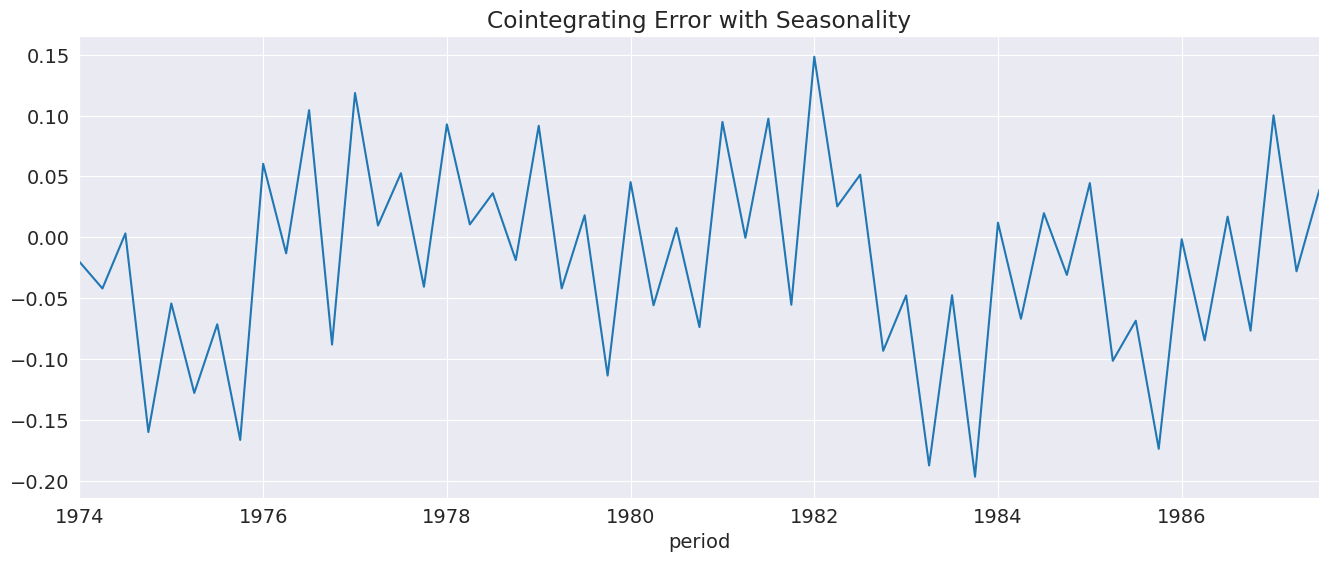

In [18]:
_ = seasonal_ecm_res.ci_resids.plot(title="Cointegrating Error with Seasonality")

## The relationship between Consumption and Growth

Here we look at an example from Greene's _Econometric analysis_ which focuses on teh long-run relationship between consumption and growth. We start by downloading the raw data.

Greene, W. H. (2000). Econometric analysis 4th edition. International edition, New Jersey: Prentice Hall, 201-215.

In [19]:
greene = pd.read_fwf(
    "https://raw.githubusercontent.com/statsmodels/smdatasets/main/data/autoregressive-distributed-lag/green/ardl_data.txt"
)
greene.head()

,Year,qtr,realgdp,realcons,realinvs realgovt realdpi cpi_u M1,tbilrate,unemp,pop,infl,realint
0,1950.0,1.0,1610.5,1058.9,198.1 361.0 1186.1 70.6 110.20,1.12,6.4,149.461,0.0000,0.0000
1,1950.0,2.0,1658.8,1075.9,220.4 366.4 1178.1 71.4 111.75,1.17,5.6,150.260,4.5071,-3.3404
2,1950.0,3.0,1723.0,1131.0,239.7 359.6 1196.5 73.2 112.95,1.23,4.6,151.064,9.9590,-8.7290
3,1950.0,4.0,1753.9,1097.6,271.8 382.5 1210.0 74.9 113.93,1.35,4.2,151.871,9.1834,-7.8301
4,1951.0,1.0,1773.5,1122.8,242.9 421.9 1207.9 77.3 115.08,1.40,3.5,152.393,12.6160,-11.2160


We then transform the index to be a pandas `DatetimeIndex` so that we can easily use seasonal terms.

In [20]:
index = pd.to_datetime(
    greene.Year.astype("int").astype("str")
    + "Q"
    + greene.qtr.astype("int").astype("str")
)
greene.index = index
greene.index.freq = greene.index.inferred_freq
greene.head()

/tmp/ipykernel_5614/2457281465.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  index = pd.to_datetime(


,Year,qtr,realgdp,realcons,realinvs realgovt realdpi cpi_u M1,tbilrate,unemp,pop,infl,realint
1950-01-01,1950.0,1.0,1610.5,1058.9,198.1 361.0 1186.1 70.6 110.20,1.12,6.4,149.461,0.0000,0.0000
1950-04-01,1950.0,2.0,1658.8,1075.9,220.4 366.4 1178.1 71.4 111.75,1.17,5.6,150.260,4.5071,-3.3404
1950-07-01,1950.0,3.0,1723.0,1131.0,239.7 359.6 1196.5 73.2 112.95,1.23,4.6,151.064,9.9590,-8.7290
1950-10-01,1950.0,4.0,1753.9,1097.6,271.8 382.5 1210.0 74.9 113.93,1.35,4.2,151.871,9.1834,-7.8301
1951-01-01,1951.0,1.0,1773.5,1122.8,242.9 421.9 1207.9 77.3 115.08,1.40,3.5,152.393,12.6160,-11.2160


We defined `g` as the log of real gdp and `c` as the log of real consumption.

In [21]:
greene["c"] = np.log(greene.realcons)
greene["g"] = np.log(greene.realgdp)

### Lag Length Selection

The selected model contains 5 lags of consumption and 2 of growth (0 and 1). Here we include seasonal terms although these are not significant.

In [22]:
sel_res = ardl_select_order(
    greene.c, 8, greene[["g"]], 8, trend="c", seasonal=True, ic="aic"
)
ardl = sel_res.model
ardl.ardl_order

(5, 1)

In [23]:
res = ardl.fit(use_t=True)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      c   No. Observations:                  204
Model:               Seas. ARDL(5, 1)   Log Likelihood                 747.939
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Mon, 08 Sep 2025   AIC                          -1471.878
Time:                        14:04:46   BIC                          -1432.358
Sample:                    04-01-1951   HQIC                         -1455.883
                         - 10-01-2000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0586      0.028     -2.103      0.037      -0.113      -0.004
s(2,4)        -0.0001      0.001     -0.087      0.930      -0.002       0.002
s(3,4)         0.0012      0.001      1.026      0.306      -0.001       0.004
s(4,4)         0.0003      0.001      0.296      0.768      -0.002       0.003
c.L1           0.8545      0.064     13.263      0.000       0.727       0.982
c.L2           0.2588      0.082      3.151      0.002       0.097       0.421
c.L3          -0.1566      0.072     -2.190      0.030      -0.298      -0.016
c.L4          -0.1941      0.070     -2.754      0.006      -0.333      -0.055
c.L5           0.1695      0.048      3.495      0.001       0.074       0.265
g.L0           0.5476      0.048     11.350      0.000       0.452       0.643
g.L1          -0.4757      0.051     -9.311      0.000      -0.576      -0.375
==============================================================================
"""

`from_ardl` is a simple way to get the equivalent UECM specification. Here we rerun the selection without the seasonal terms.

In [24]:
sel_res = ardl_select_order(greene.c, 8, greene[["g"]], 8, trend="c", ic="aic")

uecm = UECM.from_ardl(sel_res.model)
uecm_res = uecm.fit()
uecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:                    D.c   No. Observations:                  204
Model:                     UECM(5, 1)   Log Likelihood                 747.131
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Mon, 08 Sep 2025   AIC                          -1476.262
Time:                        14:04:47   BIC                          -1446.622
Sample:                    04-01-1951   HQIC                         -1464.266
                         - 10-01-2000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0586      0.028     -2.115      0.036      -0.113      -0.004
c.L1          -0.0684      0.028     -2.406      0.017      -0.125      -0.012
g.L1           0.0725      0.030      2.400      0.017       0.013       0.132
D.c.L1        -0.0767      0.059     -1.302      0.195      -0.193       0.040
D.c.L2         0.1842      0.053      3.495      0.001       0.080       0.288
D.c.L3         0.0198      0.049      0.404      0.687      -0.077       0.116
D.c.L4        -0.1664      0.048     -3.460      0.001      -0.261      -0.072
D.g.L0         0.5440      0.048     11.372      0.000       0.450       0.638
==============================================================================
"""

We see that for every % increase in consumption, we need a 1.05% increase in gdp. In other words, the saving rate is estimated to be around 5%.

In [25]:
uecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.8572,0.112,7.632,0.000,0.636,1.079
c.L1,1.0000,0,nan,nan,1.000,1.000
g.L1,-1.0590,0.013,-83.157,0.000,-1.084,-1.034


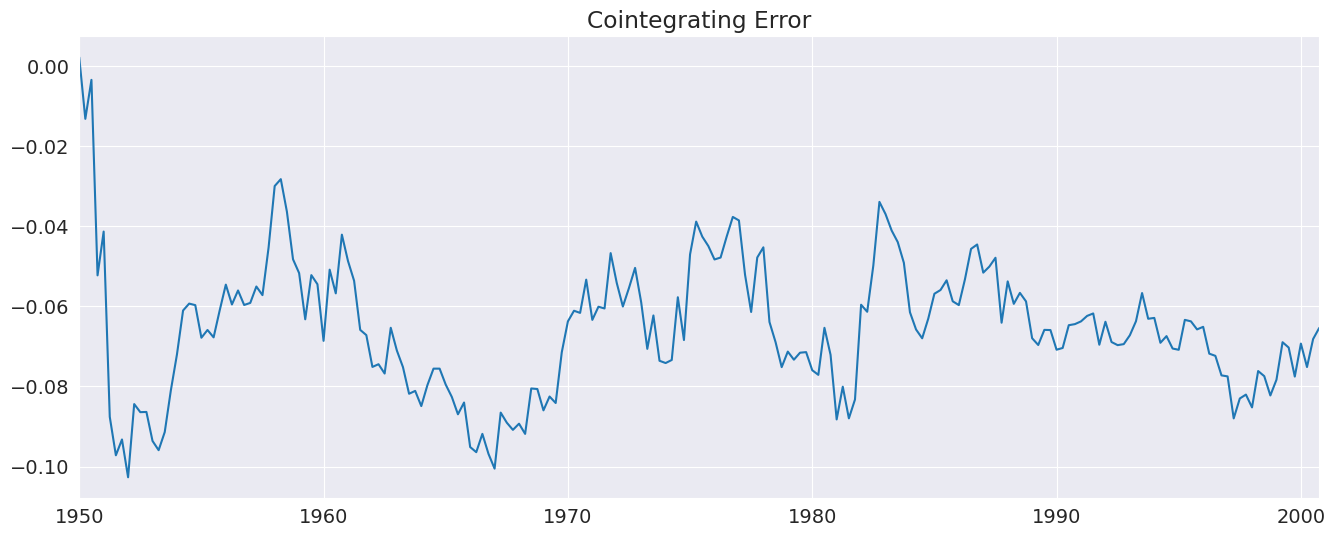

In [26]:
_ = uecm_res.ci_resids.plot(title="Cointegrating Error")

### Direct Specification of `UECM` models

`UECM` can be used to directly specify model lag lengths.

In [27]:
uecm = UECM(greene.c, 2, greene[["g"]], 1, trend="c")
uecm_res = uecm.fit()
uecm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:                    D.c   No. Observations:                  204
Model:                     UECM(2, 1)   Log Likelihood                 724.499
Method:               Conditional MLE   S.D. of innovations              0.007
Date:                Mon, 08 Sep 2025   AIC                          -1436.998
Time:                        14:04:47   BIC                          -1417.149
Sample:                    07-01-1950   HQIC                         -1428.967
                         - 10-01-2000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0778      0.030     -2.601      0.010      -0.137      -0.019
c.L1          -0.0885      0.031     -2.854      0.005      -0.150      -0.027
g.L1           0.0939      0.033      2.857      0.005       0.029       0.159
D.c.L1        -0.1926      0.058     -3.340      0.001      -0.306      -0.079
D.g.L0         0.6395      0.053     12.050      0.000       0.535       0.744
==============================================================================
"""

The changes in the lag structure make little difference in the estimated long-run relationship.

In [28]:
uecm_res.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.8789,0.096,9.183,0.000,0.690,1.068
c.L1,1.0000,0,nan,nan,1.000,1.000
g.L1,-1.0605,0.011,-94.148,0.000,-1.083,-1.038


## Bounds Testing

`UECMResults` expose the bounds test of Pesaran, Shin, and Smith (2001).  This test facilitates testing whether there is a level relationship between a set of variables without identifying which variables are I(1). This test provides two sets of critical and p-values.  If the test statistic is below the critical value for the lower bound, then there appears to be no levels relationship irrespective of the order or integration in the $X$ variables.  If it is above the upper bound, then there appears to be a levels relationship again, irrespective of the order of integration of the $X$ variables. There are 5 cases covered in the paper that include different combinations of deterministic regressors in the model or the test.


$$\Delta Y_{t}=\delta_{0} + \delta_{1}t + Z_{t-1}\beta + \sum_{j=0}^{P}\Delta X_{t-j}\Gamma + \epsilon_{t}$$

where $Z_{t-1}$ includes both $Y_{t-1}$ and $X_{t-1}$.

The cases determine which deterministic terms are included in the model and which are tested as part of the test.

1. No deterministic terms
2. Constant included in both the model and the test
3. Constant included in the model but not in the test
4. Constant and trend included in the model, only trend included in the test
5. Constant and trend included in the model, neither included in the test

Here we run the test on the Danish money demand data set. Here we see the test statistic is above the 95% critical value for both the lower and upper.


Pesaran, M. H., Shin, Y., & Smith, R. J. (2001). Bounds testing approaches to the analysis of level relationships. Journal of applied econometrics, 16(3), 289-326.

In [29]:
ecm = UECM(data.lrm, 3, data[["lry", "ibo", "ide"]], 3, trend="c")
ecm_fit = ecm.fit()
bounds_test = ecm_fit.bounds_test(case=4)
bounds_test

BoundsTestResult
Stat: 5.07063
Upper P-value: 0.0068
Lower P-value: 0.000751
Null: No Cointegration
Alternative: Possible Cointegration

In [30]:
bounds_test.crit_vals

,lower,upper
percentile,,
90.0,2.690222,3.523115
95.0,3.069910,3.957893
99.0,3.877333,4.867071
99.9,4.940583,6.040331


Case 3 also rejects the null of no levels relationship.

In [31]:
ecm = UECM(data.lrm, 3, data[["lry", "ibo", "ide"]], 3, trend="c")
ecm_fit = ecm.fit()
bounds_test = ecm_fit.bounds_test(case=3)
bounds_test

BoundsTestResult
Stat: 5.99305
Upper P-value: 0.00205
Lower P-value: 0.000138
Null: No Cointegration
Alternative: Possible Cointegration